<a href="https://www.kaggle.com/code/danish2op/nn-for-mnist?scriptVersionId=187920640" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
np.random.seed(0)
random.seed(0)

In [2]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) 


In [3]:
data_dev = data[0:28000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

In [4]:
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [5]:
def init_params():
    W1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    W2 = np.random.rand(64, 128) - 0.5
    b2 = np.random.rand(64, 1) - 0.5
    W3 = np.random.rand(10, 64) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2, W3, b3




In [6]:
# Activation functions and their derivatives
def LeakyReLU(Z, alpha=0.01):
    return np.maximum(alpha * Z, Z)

def ELU(Z, alpha=1.0):
    return np.where(Z > 0, Z, alpha * (np.exp(Z) - 1))

def ReLU(Z):
    return np.maximum(0, Z)

def LeakyReLU_deriv(Z, alpha=0.01):
    return np.where(Z > 0, 1, alpha)

def ELU_deriv(Z, alpha=1.0):
    return np.where(Z > 0, 1, alpha * np.exp(Z))

def ReLU_deriv(Z):
    return np.where(Z > 0, 1, 0)

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_deriv(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))


In [7]:
def forward_prop(W1, b1, W2, b2, W3, b3, X, activation_hidden1, activation_hidden2):
    Z1 = W1.dot(X) + b1
    A1 = activation_hidden1(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = activation_hidden2(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3


In [8]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


In [9]:
def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, activation_hidden1_deriv, activation_hidden2_deriv):
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = W3.T.dot(dZ3) * activation_hidden2_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * activation_hidden1_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2, dW3, db3


In [10]:
def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3


In [11]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size


In [12]:
def gradient_descent(X, Y, alpha, iterations, activation_hidden1, activation_hidden2, activation_hidden1_deriv, activation_hidden2_deriv):
    W1, b1, W2, b2, W3, b3 = init_params()
    accuracy_list = []
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X, activation_hidden1, activation_hidden2)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, activation_hidden1_deriv, activation_hidden2_deriv)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        if i % 10 == 0:
            predictions = np.argmax(A3, axis=0)
            accuracy = get_accuracy(predictions, Y)
            accuracy_list.append(accuracy)
            print(f"Iteration {i}: {accuracy}")
    return W1, b1, W2, b2, W3, b3, accuracy_list


In [13]:
def make_predictions(X, W1, b1, W2, b2, W3, b3, activation_hidden1, activation_hidden2):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X, activation_hidden1, activation_hidden2)
    predictions = np.argmax(A3, axis=0)
    return predictions


In [14]:
print("training with LeakyReLU and ELU")
W1, b1, W2, b2, W3, b3, accuracy_list_leaky_elu = gradient_descent(
    X_dev, Y_dev, 0.10, 500, LeakyReLU, ELU, LeakyReLU_deriv, ELU_deriv)

predictions_test_leaky_elu = make_predictions(X_dev, W1, b1, W2, b2, W3, b3, LeakyReLU, ELU)


training with LeakyReLU and ELU
Iteration 0: 0.061642857142857145
Iteration 10: 0.5470357142857143
Iteration 20: 0.6481428571428571
Iteration 30: 0.6991071428571428
Iteration 40: 0.7315714285714285
Iteration 50: 0.7533214285714286
Iteration 60: 0.7705
Iteration 70: 0.7848571428571428
Iteration 80: 0.796
Iteration 90: 0.8059642857142857
Iteration 100: 0.8149642857142857
Iteration 110: 0.8224642857142858
Iteration 120: 0.8289642857142857
Iteration 130: 0.8353928571428572
Iteration 140: 0.84025
Iteration 150: 0.8443214285714286
Iteration 160: 0.8489642857142857
Iteration 170: 0.8530714285714286
Iteration 180: 0.8567857142857143
Iteration 190: 0.8596785714285714
Iteration 200: 0.8624642857142857
Iteration 210: 0.8648571428571429
Iteration 220: 0.8670357142857142
Iteration 230: 0.8706785714285714
Iteration 240: 0.873
Iteration 250: 0.8753928571428572
Iteration 260: 0.8774642857142857
Iteration 270: 0.8797857142857143
Iteration 280: 0.8814285714285715
Iteration 290: 0.8830357142857143
Iterat

In [15]:
# Training and testing with ReLU
print("training with only ReLU")
W1, b1, W2, b2, W3, b3, accuracy_list_relu = gradient_descent(
    X_train, Y_train, 0.10, 500, ReLU, ReLU, ReLU_deriv, ReLU_deriv)

predictions_test_relu = make_predictions(X_dev, W1, b1, W2, b2, W3, b3, ReLU, ReLU)


training with only ReLU
Iteration 0: 0.09407317073170732
Iteration 10: 0.5407317073170732
Iteration 20: 0.6392926829268293
Iteration 30: 0.6962926829268292
Iteration 40: 0.7335121951219512
Iteration 50: 0.7581951219512195
Iteration 60: 0.7779268292682927
Iteration 70: 0.7941219512195122
Iteration 80: 0.8069512195121952
Iteration 90: 0.8175365853658536
Iteration 100: 0.8260975609756097
Iteration 110: 0.8329512195121951
Iteration 120: 0.8385853658536585
Iteration 130: 0.844609756097561
Iteration 140: 0.8499268292682927
Iteration 150: 0.854780487804878
Iteration 160: 0.8591219512195122
Iteration 170: 0.8631219512195122
Iteration 180: 0.8670243902439024
Iteration 190: 0.8700487804878049
Iteration 200: 0.8730243902439024
Iteration 210: 0.8759268292682927
Iteration 220: 0.8788292682926829
Iteration 230: 0.8812926829268293
Iteration 240: 0.8832682926829268
Iteration 250: 0.8851219512195122
Iteration 260: 0.8868292682926829
Iteration 270: 0.8887804878048781
Iteration 280: 0.8905365853658537
It

In [16]:
print("training with Sigmoid")
W1, b1, W2, b2, W3, b3, accuracy_list_sigmoid = gradient_descent(
    X_dev, Y_dev, 0.10, 500, sigmoid, sigmoid, sigmoid_deriv, sigmoid_deriv)

predictions_test_sigmoid = make_predictions(X_dev, W1, b1, W2, b2, W3, b3, sigmoid, sigmoid)


training with Sigmoid
Iteration 0: 0.08021428571428571
Iteration 10: 0.12603571428571428
Iteration 20: 0.1984642857142857
Iteration 30: 0.2596785714285714
Iteration 40: 0.31657142857142856
Iteration 50: 0.3667142857142857
Iteration 60: 0.41010714285714284
Iteration 70: 0.45135714285714285
Iteration 80: 0.48432142857142857
Iteration 90: 0.5129642857142858
Iteration 100: 0.5385714285714286
Iteration 110: 0.5612857142857143
Iteration 120: 0.5829642857142857
Iteration 130: 0.6021071428571428
Iteration 140: 0.61875
Iteration 150: 0.6342857142857142
Iteration 160: 0.6478214285714285
Iteration 170: 0.6581071428571429
Iteration 180: 0.6685357142857142
Iteration 190: 0.6782142857142858
Iteration 200: 0.6866428571428571
Iteration 210: 0.6947857142857143
Iteration 220: 0.7021785714285714
Iteration 230: 0.7083214285714285
Iteration 240: 0.7145714285714285
Iteration 250: 0.7213571428571428
Iteration 260: 0.7278571428571429
Iteration 270: 0.7336071428571429
Iteration 280: 0.7391071428571429
Iteratio

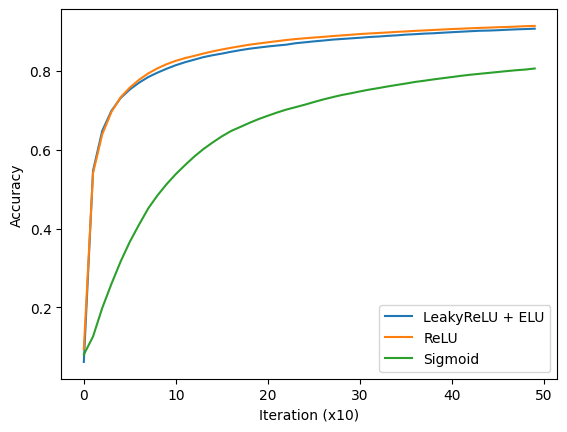

In [17]:
plt.plot(accuracy_list_leaky_elu, label='LeakyReLU + ELU')
plt.plot(accuracy_list_relu, label='ReLU')
plt.plot(accuracy_list_sigmoid, label='Sigmoid')
plt.xlabel('Iteration (x10)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3, LeakyReLU,ELU)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [9]
Label:  4


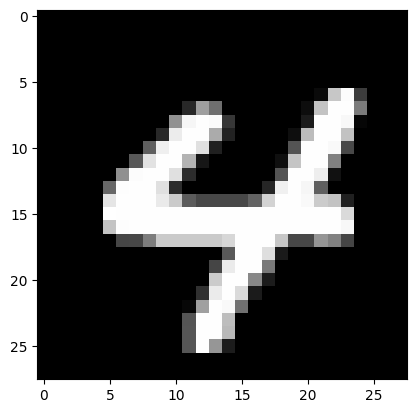

In [19]:
test_prediction(0, W1, b1, W2, b2, W3, b3)